<a href="https://colab.research.google.com/github/sswapnil2/ml-code/blob/master/gans_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__  import print_function, division, absolute_import

In [0]:
from __future__ import unicode_literals

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-beta1'

In [6]:
# to generate GIFS
!pip install imageio

In [0]:
import glob 
import imageio
import matplotlib.pyplot as plt 
import numpy as np
import os 
import PIL
from tensorflow.keras import layers
import time

from IPython import display

 ## Load dataset

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) /127.5 #normalize the image

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

In [0]:
# create the generator and descriminator using keras sequential api's

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

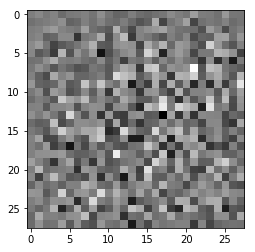

In [14]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap="gray")

generator.summary()

In [0]:
# descriminator model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
descriminator = make_discriminator_model()
decision = descriminator(generated_image)
print(generated_image.shape)
print (decision)
descriminator.summary()

(1, 28, 28, 1)
tf.Tensor([[0.00214231]], shape=(1, 1), dtype=float32)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
__________________________________________________

## DEfine the loss and optimizers

In [0]:
# this method returns a helper function to compute cross entropy loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Descriminator Loss

In [0]:
def descriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
descriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## Save checkpoints

In [0]:
checkpoints_dir = './training_checkpoints'

checkpoints_prefix = os.path.join(checkpoints_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    descriminator_optimizer=descriminator_optimizer,
    generator=generator,
    descriminator=descriminator)


In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      print(f"images {images.shape} generated_images {generated_images}")
      real_output = descriminator(images, training=True)
      fake_output = descriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = descriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, descriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    descriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,  descriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # produce images for GIF as we go 
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    #save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoints_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

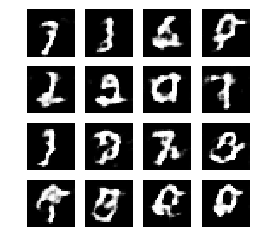

Time for epoch 22 is 27.073747396469116 sec


In [0]:
# %%time
train(dataset, EPOCHS)